<a href="https://colab.research.google.com/github/magoangadsingh/iot-health-monitor/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # ⬅️ Select kaggle.json from your computer


Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"angadmago","key":"f4ffb7013b4c4818b77d175fb4e1a1dc"}'}

In [ ]:
# Run this cell to install necessary packages and mount Kaggle
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload your kaggle.json here

# Setup Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the IoMT dataset
!kaggle datasets download -d prokashbarmancu/iomt-alert
!unzip iomt-alert.zip


Saving patients_data_with_alerts.xlsx to patients_data_with_alerts (3).xlsx
Dataset URL: https://www.kaggle.com/datasets/prokashbarmancu/iomt-alert
License(s): other
iomt-alert.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  iomt-alert.zip
replace patients_data_with_alerts.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: patients_data_with_alerts.xlsx  


In [ ]:
import pandas as pd

# Load the Excel file
df = pd.read_excel("patients_data_with_alerts.xlsx")
df.head()



,Patient Number,Heart Rate (bpm),SpO2 Level (%),Systolic Blood Pressure (mmHg),Diastolic Blood Pressure (mmHg),Body Temperature (°C),Fall Detection,Predicted Disease,Data Accuracy (%),Heart Rate Alert,SpO2 Level Alert,Blood Pressure Alert,Temperature Alert
0,1,96,92,101,89,36.904680,No,Diabetes Mellitus,95,Normal,Normal,Normal,Normal
1,2,76,83,103,85,37.254129,Yes,Asthma,91,Normal,Low,Normal,Abnormal
2,3,92,88,123,70,36.539418,Yes,Asthma,86,Normal,Low,Normal,Normal
3,4,137,84,167,97,37.018767,Yes,Asthma,99,High,Low,High,Normal
4,5,76,81,175,80,37.328671,No,Normal,93,Normal,Low,High,Abnormal


In [ ]:


# Load Excel file
df = pd.read_excel("patients_data_with_alerts.xlsx")

# Normalize column names
df.columns = df.columns.str.lower()



In [ ]:
# Count how many alerts are not "Normal"
def count_abnormal(row):
    return sum(x.strip().lower() != "normal" for x in row)

df['label'] = df[['heart rate alert', 'spo2 level alert', 'blood pressure alert', 'temperature alert']].apply(
    count_abnormal, axis=1)

# Map count to status
def map_label(x):
    if x == 0:
        return 0  # Normal
    elif x <= 2:
        return 1  # Warning
    else:
        return 2  # Critical

df['label'] = df['label'].apply(map_label)

df[['heart rate alert', 'spo2 level alert', 'blood pressure alert', 'temperature alert', 'label']].head()



,heart rate alert,spo2 level alert,blood pressure alert,temperature alert,label
0,Normal,Normal,Normal,Normal,0
1,Normal,Low,Normal,Abnormal,1
2,Normal,Low,Normal,Normal,1
3,High,Low,High,Normal,2
4,Normal,Low,High,Abnormal,2


In [ ]:
X = df[['heart rate (bpm)', 'spo2 level (%)', 'body temperature (°c)']]
y = df['label']

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train_scaled, y_train)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Split the data stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Step 2: Handle class imbalance using SMOTE (optional but recommended)
print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))

# Step 3: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the model
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train_scaled, y_train_resampled)

# Step 5: Evaluate
print("Training accuracy:", model.score(X_train_scaled, y_train_resampled))
print("Test accuracy:", model.score(X_test_scaled, y_test))

# Optional Step 6: Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, scaler.transform(X), y, cv=cv)

print(f"Cross-validation accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")



Before SMOTE: Counter({1: 24155, 2: 13898, 0: 1947})
After SMOTE: Counter({1: 24155, 2: 24155, 0: 24155})
Training accuracy: 0.8766300972883461
Test accuracy: 0.7675
Cross-validation accuracy: 0.80 ± 0.00


              precision    recall  f1-score   support

           0       0.40      0.99      0.56       487
           1       0.99      0.62      0.76      6039
           2       0.69      0.99      0.81      3474

    accuracy                           0.77     10000
   macro avg       0.69      0.87      0.71     10000
weighted avg       0.86      0.77      0.77     10000



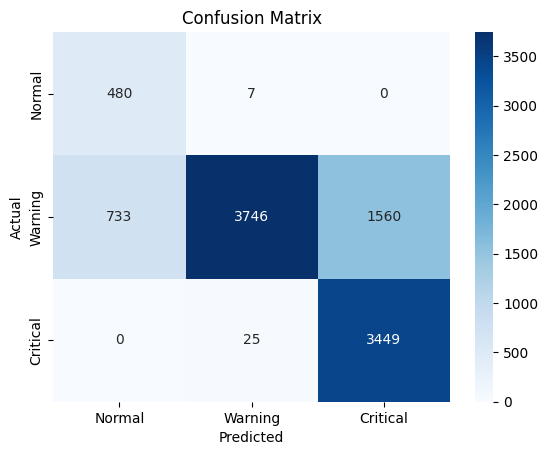

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Warning", "Critical"],
            yticklabels=["Normal", "Warning", "Critical"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


✅ Model Accuracy: 76.75%

📊 Classification Report:
               precision    recall  f1-score   support

      Normal       0.40      0.99      0.56       487
     Warning       0.99      0.62      0.76      6039
    Critical       0.69      0.99      0.81      3474

    accuracy                           0.77     10000
   macro avg       0.69      0.87      0.71     10000
weighted avg       0.86      0.77      0.77     10000



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


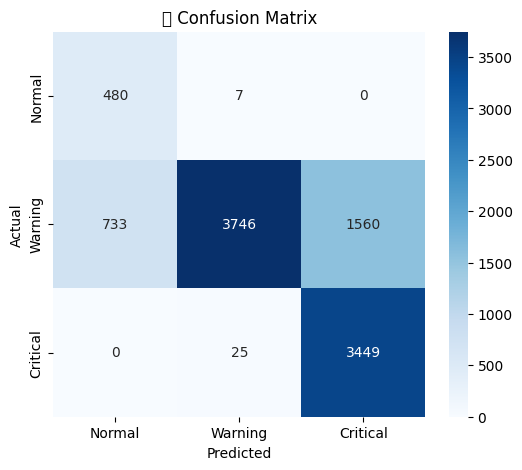

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print(f"✅ Model Accuracy: {acc:.2f}%")

# Classification report (per class)
report = classification_report(y_test, y_pred, target_names=["Normal", "Warning", "Critical"])
print("\n📊 Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Warning", "Critical"],
            yticklabels=["Normal", "Warning", "Critical"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧾 Confusion Matrix")
plt.show()


Before SMOTE: Counter({1: 24155, 2: 13898, 0: 1947})
After SMOTE: Counter({1: 24155, 2: 24155, 0: 24155})


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 1.0

Confusion Matrix:
 [[ 487    0    0]
 [   0 6039    0]
 [   0    0 3474]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       487
           1       1.00      1.00      1.00      6039
           2       1.00      1.00      1.00      3474

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validation accuracy: 1.00 ± 0.00


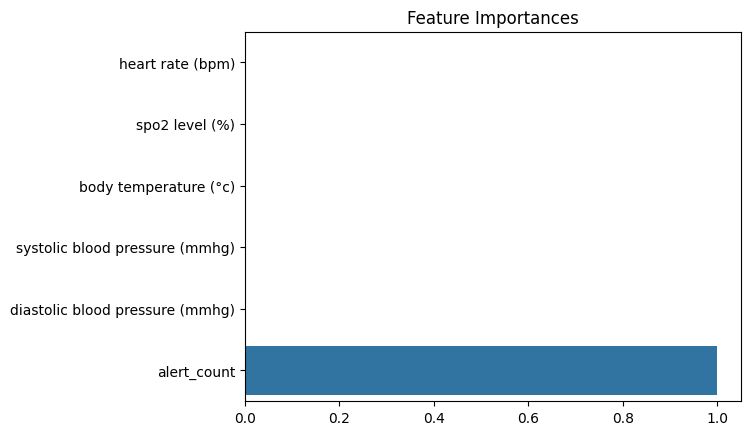

In [ ]:
# Load the Excel file (make sure the file is already uploaded)
df = pd.read_excel("patients_data_with_alerts.xlsx")

# Normalize column names
df.columns = df.columns.str.lower()

import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize column names
df.columns = df.columns.str.lower()

# Step 1: Label Engineering — already done earlier
def count_abnormal(row):
    return sum(x.strip().lower() != "normal" for x in row)

df['label'] = df[['heart rate alert', 'spo2 level alert', 'blood pressure alert', 'temperature alert']].apply(
    count_abnormal, axis=1)

def map_label(x):
    if x == 0:
        return 0  # Normal
    elif x <= 2:
        return 1  # Warning
    else:
        return 2  # Critical

df['label'] = df['label'].apply(map_label)

# Step 2: Feature Engineering
df['alert_count'] = df[['heart rate alert', 'spo2 level alert', 'blood pressure alert', 'temperature alert']].apply(
    lambda row: sum(x.strip().lower() != "normal" for x in row), axis=1)

features = ['heart rate (bpm)', 'spo2 level (%)', 'body temperature (°c)',
            'systolic blood pressure (mmhg)', 'diastolic blood pressure (mmhg)', 'alert_count']

X = df[features]
y = df['label']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 4: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: SMOTE for balancing
print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", Counter(y_train_smote))

# Step 6: Train XGBoost
model = XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_smote, y_train_smote)

# Step 7: Evaluation
y_pred = model.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 8: Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Step 9: Feature Importance
importances = model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()